# Compute tSZ power spectrum with JAX

## Initialize

In [1177]:
import numpy as np
import mcfit
from mcfit import TophatVar
import jax
import jax.numpy as jnp
import jax.scipy as jscipy
from jax.scipy.interpolate import RegularGridInterpolator
# from jax.scipy.integrate import trapezoid
import functools
import matplotlib.pyplot as plt
from classy_sz import Class as Class_sz
# from scipy.integrate import simpson

In [1178]:
allpars = {
    'omega_b': 0.02242,
    'omega_cdm':  0.11933,
    'H0': 67.66, 
    'tau_reio': 0.0561,
    'ln10^{10}A_s': 3.047,
    'n_s': 0.9665, 
    "cosmo_model": 0, # use mnu-lcdm emulators

    "ell_min" : 2,
    "ell_max" : 8000,

    'dlogell': 0.2,
    'z_min' : 0.005,
    'z_max' : 3.0,
    'M_min' : 1.0e10, 
    'M_max' : 3.5e15,
    
    "P0GNFW": 8.130,
    "c500": 1.156,
    "gammaGNFW": 0.3292,
    "alphaGNFW": 1.0620,
    "betaGNFW":5.4807,
    "B": 1.0,
    "jax": 1,
}

In [1179]:
classy_sz = Class_sz()
classy_sz.set(allpars)
classy_sz.set({
# 'output':'',
'pressure_profile':'GNFW', # can be Battaglia, Arnaud, etc
})
classy_sz.compute_class_szfast()
# par_dict = classy_sz.get_all_relevant_params()

/Users/licongxu/envs/jax_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: DeprecationWarning: compute_class_szfast is deprecated. Use initialize_classy_szfast instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [1180]:
# pks, ks = classy_sz.get_pkl_at_z(1, params_values_dict=par_dict)
# pks

## Define Hankel transform of pressure profile

In [1181]:
def gnfw_pressure_profile(x, z, m, params_values_dict = None):
    """
    GNFW pressure profile
    """
    # Obtain cosmological parameters from classy_sz
    rparams = classy_sz.get_all_relevant_params(params_values_dict = params_values_dict)
    # rparams = classy_sz.pars
    conv_fac = 299792.458 # speed of light
    h = rparams['H0']/100
    H = classy_sz.get_hubble_at_z(z, params_values_dict = params_values_dict) * conv_fac  # Hubble parameter at given z
    H0 = rparams['H0']  # Hubble parameter at z=0

    # GNFW prefactor
    B = rparams['B']    
    m_delta_tilde = (m / B) # convert to M_sun 
    C = 1.65 * (h / 0.7)**2 * (H / H0)**(8 / 3) * (m_delta_tilde / (0.7 * 3e14))**(2 / 3 + 0.12) * (0.7/h)**1.5 # eV cm^-3
    # C = 1.65 * (h / 0.7)**2 * (H / H0)**(8 / 3) * (m_delta_tilde / (0.7 * 3e14))**(2 / 3 + 0.12) # eV cm^-3
    c500 = rparams['c500']
    gamma = rparams['gammaGNFW']
    alpha = rparams['alphaGNFW']
    beta = rparams['betaGNFW']
    P0 = rparams['P0GNFW']

    # Calculate scaled radius and pressure profile
    scaled_x = c500 * x
    term1 = scaled_x**(-gamma)
    term2 = (1 + scaled_x**alpha)**((gamma - beta) / alpha)
    Pe = C * P0 * term1 * term2

    return Pe


In [1182]:
def window_function(x, x_min, x_max):
    """
    Since the integral is between x_min and x_max
    """

    return np.where((x >= x_min) & (x <= x_max), 1.0, 0.0)

In [1183]:
def hankel_integrand(x, z, m, x_min=1e-6, x_max=4, params_values_dict = None):
    """
    Compute x^0.5 * Pe(x) * W(x).
    Handles x and m as arrays using vmap for vectorization.
    """
    # Vectorize over m
    def single_m(m_val, params_values_dict = params_values_dict):
        # Compute GNFW pressure profile for given m
        Pe = gnfw_pressure_profile(x, z, m_val, params_values_dict = params_values_dict)
        
        # Compute the window function
        W_x = window_function(x, x_min, x_max)
        
        # Combine the result
        return x**0.5 * Pe * W_x
    
    # Apply vmap to vectorize over m
    result = jax.vmap(single_m)(m)
    
    return result  # Shape: (len(m), len(x))

In [1184]:
def mpc_per_h_to_cm(mpc_per_h, h):
    """
    Converts a distance in Mpc/h to centimeters.
    """
    # 1 megaparsec (Mpc) in centimeters
    Mpc_to_cm = 3.085677581e24  # cm

    # Convert Mpc/h to Mpc by dividing by h
    mpc = mpc_per_h / h

    # Convert Mpc to cm
    cm = mpc * Mpc_to_cm

    return cm

In [1185]:
def y_ell_prefactor(z, m, delta = 500, params_values_dict = None): 
    
    rparams = classy_sz.get_all_relevant_params(params_values_dict = params_values_dict)
    # rparams = classy_sz.pars
    h = rparams['H0']/100
    B = rparams['B']

    # print(rparams)
    me_in_eV = 510998.95 # electron mass in eV/c^2
    # me_in_eV = 511000 # electron mass in eV/c^2
    sigmat_cm = 6.6524587321e-25 # Thomson cross section in cm^2
    sigmat_over_mec2 = sigmat_cm / me_in_eV
    # sigmat_over_mec2 = 283.2980000259841 / 0.5176

    dAz = classy_sz.get_angular_distance_at_z(z,params_values_dict = params_values_dict)*h
    # dAz = classy_sz.get_angular_distance_at_z(z,params_values_dict = params_values_dict)/(1+z)*h # in Mpc/h
    r_delta = classy_sz.get_r_delta_of_m_delta_at_z(delta, m, z, params_values_dict = params_values_dict)/(B**(1/3))  # in Mpc/h
    ell_delta = dAz/r_delta
    # print(ell_delta)
    h = rparams['H0']/100

    r_delta_cm = mpc_per_h_to_cm(r_delta, h)  # r is in cm 
    # print(r_delta_cm/ell_delta**2)
    # print(sigmat_over_mec2)

    prefactor = sigmat_over_mec2 * 4 * np.pi * r_delta_cm/(ell_delta**2)

    return prefactor

In [1186]:
def y_ell_complete(z, m, x_min=1e-6, x_max=4, params_values_dict = None):

    rparams = classy_sz.get_all_relevant_params(params_values_dict = params_values_dict)
    h = rparams['H0']/100
    B = rparams['B']
    
    prefactor = y_ell_prefactor(z, m, params_values_dict=params_values_dict)
    # print(prefactor)
    # Define x in logarithmic space
    x = jnp.logspace(jnp.log10(1e-4), jnp.log10(1e3), num=512)  # Avoid x = 0 to prevent divergence

    integrand = hankel_integrand(x, z, m, x_min=1e-6, x_max=4, params_values_dict=params_values_dict)
    # print(integrand)

    # Hankel transform with JAX
    H = mcfit.Hankel(x, nu=0.5, lowring=True, backend='jax') 
    H_jit = jax.jit(functools.partial(H, extrap=False))

    k, y_k = H_jit(integrand) # Note that k = ell/ell_delta
    # print(k)
    # print(y_k)

    dAz = classy_sz.get_angular_distance_at_z(z, params_values_dict = params_values_dict) * h # in Mpc/h
    # dAz = classy_sz.get_angular_distance_at_z(z,params_values_dict = params_values_dict)/(1+z)*h # in Mpc/h

    delta = 500
    r_delta = classy_sz.get_r_delta_of_m_delta_at_z(delta, m, z, params_values_dict = params_values_dict)/(B**(1/3))  # in Mpc/h
    # print(r_delta)
    ell_delta = dAz/r_delta
    # print(ell_delta)

    ell = jnp.zeros(ell_delta.shape)
    # ell = k * ell_delta  # Note that k = ell/ell_delta
    ell = k[None, :] * ell_delta[:, None]
    # print("shape  of ell:", ell.shape)


    # print("shape of k:", k.shape)
    # print("shape of ell_delta:", ell_delta.shape)

    # print(ell)
    # print(ell_delta[:, None].shape)
    # print(k[None, :])
    # print(y_k.shape)
    # print(prefactor.shape)
    # print(prefactor[:, None])

    # y_ell = prefactor * y_k * np.sqrt(np.pi/(2*k)) # multiply the prefactor of spherical Bessel to Hankel
    y_ell = prefactor[:, None] * y_k * jnp.sqrt(jnp.pi / (2 * k[None, :]))

    return ell, y_ell

## Interpolator of $y_\ell$

In [1187]:
def y_ell_interpolate(z, m, params_values_dict = None):
    """
    Interpolate y_ell values onto a uniform ell grid for multiple m values.
    """
    # Get cosmological parameters
    rparams = classy_sz.get_all_relevant_params(params_values_dict = params_values_dict)
    l_min = rparams['ell_min']
    l_max = rparams['ell_max']
    dlogell = rparams['dlogell']


    log10_l_min = jnp.log10(l_min)
    log10_l_max = jnp.log10(l_max)
    num = int((log10_l_max - log10_l_min) / dlogell) + 1
    # print(num)

    # Compute the complete y_ell values
    ell_nointer_list, y_ell_nointer_list = y_ell_complete(z, m, params_values_dict = params_values_dict)

    # Define evaluation ell values (uniform grid)
    # ell_eval = jnp.logspace(log10_l_min, log10_l_max, num=num)
    ell_eval = get_ell_range()

    # Interpolator function for a single m
    def interpolate_single(ell_nointer, y_ell_nointer):
        interpolator = RegularGridInterpolator((ell_nointer,), y_ell_nointer, method='linear', bounds_error=False, fill_value=None)
        return interpolator(ell_eval)

    # Vectorize the interpolation across all m
    interpolate_all = jax.vmap(interpolate_single, in_axes=(0, 0), out_axes=0)

    # Perform the interpolation
    y_ell_eval_list = interpolate_all(ell_nointer_list, y_ell_nointer_list)

    return ell_eval, y_ell_eval_list


In [1188]:
# m = jnp.array([3e15, 5e15])
# z = 1
# ell = y_ell_interpolate(z, m, params_values_dict=allpars)[0]
# y_ell = y_ell_interpolate(z, m, params_values_dict=allpars)[1][0]
# plt.plot(ell, y_ell, label='Interpolation', color='r')

# ell_no_inter = y_ell_complete(z, m, params_values_dict = allpars)[0][0]
# y_ell_no_inter = y_ell_complete(z, m, params_values_dict = allpars)[1][0]
# plt.plot(ell_no_inter, y_ell_no_inter, label='No Interpolation', color='b') 
# plt.xlim(1,1e5)
# # plt.ylim(1.5e-25,3e-25)
# plt.ylabel(r'$y_{\ell}$')
# plt.xlabel(r'$\ell$')
# plt.xscale('log')
# # plt.yscale('log')
# plt.legend()
# plt.show()

## Halo Mass Function (T08500c)

In [1189]:
def MF_T08(sigmas, z, delta_mean):
    # Convert delta_mean to log scale
    delta_mean = jnp.log10(delta_mean)

    # Define parameters as JAX arrays
    delta_mean_tab = jnp.log10(jnp.array([200, 300, 400, 600, 800, 1200, 1600, 2400, 3200]))
    A_tab = jnp.array([0.186, 0.200, 0.212, 0.218, 0.248, 0.255, 0.260, 0.260, 0.260])
    aa_tab = jnp.array([1.47, 1.52, 1.56, 1.61, 1.87, 2.13, 2.30, 2.53, 2.66])
    b_tab = jnp.array([2.57, 2.25, 2.05, 1.87, 1.59, 1.51, 1.46, 1.44, 1.41])
    c_tab = jnp.array([1.19, 1.27, 1.34, 1.45, 1.58, 1.80, 1.97, 2.24, 2.44])

    # Linear interpolation using jnp.interp
    Ap = jnp.interp(delta_mean, delta_mean_tab, A_tab) * (1 + z) ** -0.14
    a = jnp.interp(delta_mean, delta_mean_tab, aa_tab) * (1 + z) ** -0.06
    b = jnp.interp(delta_mean, delta_mean_tab, b_tab) * (1 + z) ** -jnp.power(10, -jnp.power(0.75 / jnp.log10(jnp.power(10, delta_mean) / 75), 1.2))
    c = jnp.interp(delta_mean, delta_mean_tab, c_tab)

    # print(a.shape,b.shape,c.shape,Ap.shape,sigmas.shape)

    # Calculate final result
    result = 0.5 * Ap[:,None] * (jnp.power(sigmas / b[:, None], -a[:, None]) + 1) * jnp.exp(-c[:, None] / sigmas**2)

    return result

In [1190]:
def MF_T08(sigmas, z, delta_mean):
    # Convert delta_mean to log scale
    delta_mean = jnp.log10(delta_mean)
    
    # Define parameters as JAX arrays
    delta_mean_tab = jnp.log10(jnp.array([200, 300, 400, 600, 800, 1200, 1600, 2400, 3200]))
    A_tab = jnp.array([0.186, 0.200, 0.212, 0.218, 0.248, 0.255, 0.260, 0.260, 0.260])
    aa_tab = jnp.array([1.47, 1.52, 1.56, 1.61, 1.87, 2.13, 2.30, 2.53, 2.66])
    b_tab = jnp.array([2.57, 2.25, 2.05, 1.87, 1.59, 1.51, 1.46, 1.44, 1.41])
    c_tab = jnp.array([1.19, 1.27, 1.34, 1.45, 1.58, 1.80, 1.97, 2.24, 2.44])

    # Linear interpolation using jnp.interp
    Ap = jnp.interp(delta_mean, delta_mean_tab, A_tab) * (1 + z) ** -0.14
    a = jnp.interp(delta_mean, delta_mean_tab, aa_tab) * (1 + z) ** -0.06
    b = jnp.interp(delta_mean, delta_mean_tab, b_tab) * (1 + z) ** -jnp.power(10, -jnp.power(0.75 / jnp.log10(jnp.power(10, delta_mean) / 75), 1.2))
    c = jnp.interp(delta_mean, delta_mean_tab, c_tab)
    
    # print(a.shape,b.shape,c.shape,Ap.shape,sigmas.shape)

    # Calculate final result
    result = 0.5 * Ap[:,None] * (jnp.power(sigmas / b[:, None], -a[:, None]) + 1) * jnp.exp(-c[:, None] / sigmas**2)

    return result

In [1191]:
def get_hmf_grid(delta = 500, delta_def = 'critical', params_values_dict = None):
    
    rparams = classy_sz.get_all_relevant_params(params_values_dict = params_values_dict)
    # print(rparams)
    h = rparams['h']
    ## initialize (get ks)
    z = 1.
    _,ks = classy_sz.get_pkl_at_z(z,params_values_dict = params_values_dict)

    # Define a single function for `get_pkl_at_z` calls
    def get_pks_for_z(zp):
        pks, ks = classy_sz.get_pkl_at_z(zp, params_values_dict= params_values_dict)
        # print(pks)
        return pks.flatten()

    # Vectorize this function over `z_grid`
    z_grid = classy_sz.z_grid()
    P = jax.vmap(get_pks_for_z)(z_grid).T

    # Vectorize the TophatVar function over `z_grid`
    def compute_tophat_var(pks, ks):
        _, var_z = TophatVar(ks, lowring=True, backend='jax')(pks, extrap=True)
        return var_z

    # Apply the function to each column of P
    var = jax.vmap(compute_tophat_var, in_axes=(1, None))(P, ks)


    # # Vectorize the TophatVar function over `z_grid`
    # def compute_tophat_dvar(pks, ks):
    #     #analytical derivatives
    #     rvar, var_z = TophatVar(ks, lowring=True, backend='jax',deriv=1)(pks*ks, extrap=True) 
        
    #     #numerical derivatives
    #     # var_z = jnp.gradient(jnp.sqrt(var),rvar)*2.*jnp.sqrt(var)
    #     # cosmocnc:  TophatVar(self.k,lowring=True,deriv=1)(self.pk*self.k,extrap=True)
    #     return var_z
        # Vectorize the TophatVar function over `z_grid`
    def compute_tophat_dvar(pks, ks, var = var):
        # analytical method: ... doesnt work.....!
        # rvar , dvar_z = TophatVar(ks, lowring=True, backend='jax',deriv=1)(pks*ks, extrap=True)
        # numerical method: 
        rvar, var_z = TophatVar(ks, lowring=True, backend='jax')(pks, extrap=True)
        dvar_z = jnp.gradient(jnp.sqrt(var_z),rvar)*2.*jnp.sqrt(var_z)
        return dvar_z


    # Apply the function to each column of P
    dvar = jax.vmap(compute_tophat_dvar, in_axes=(1, None))(P, ks)


    # Step 4: Compute gradient of var with respect to R
    # Assuming R is uniform across z_grid, use the first R from TophatVar
    R, _ = TophatVar(ks, lowring=True, backend='jax')(P[:, 0], extrap=True)
    R = R.flatten()  # Ensure R has shape (1000,)
    lnr_grid = jnp.log(R)
    lnx_grid = jnp.log(1+z_grid)
    
    
    
    lnsigma_grid = 0.5*jnp.log(var)
    
    # dvar = R*jnp.gradient(var, jnp.log(R))
    dsigma2_grid = dvar

    
    Rh = R*rparams['h']

    lnm_grid = jnp.log(4*jnp.pi*rparams['Omega0_cb']*rparams['Rho_crit_0']*Rh**3/3.) # in h-units
    
    # Define the interpolator
    # lnsigma_interpolator = jscipy.interpolate.RegularGridInterpolator((lnx_grid, lnm_grid), lnsigma_grid)
    # dsigma2_interpolator = jscipy.interpolate.RegularGridInterpolator((lnx_grid, lnm_grid), dsigma2_grid)
    # print(jnp.exp(lnm_grid)[0],jnp.exp(lnm_grid)[-1])
    if delta_def == 'critical':
        delta_mean = classy_sz.get_delta_mean_from_delta_crit_at_z(delta,z_grid,params_values_dict = params_values_dict)
    elif delta_def == 'mean':
        delta_mean = jnp.full_like(z_grid, delta)
    else:
        print("Not implemened yet")
    # print(delta_mean[0],delta_mean[-1])
    
    
    delta_c =  (3./20.)*jnp.power(12.*jnp.pi,2./3.) # this is = 1.686470199841145
    # print(delta_c)
    # note here we dont use matter dependent delta_c
    # which would be multiplied by (1.+0.012299*log10(pvecback[pba->index_bg_Omega_m]));
    
    
    sigmas = jnp.exp(lnsigma_grid)
    nus = (delta_c/sigmas)**2 ## currently for book keeping
    # print("nus",nus.shape)
    # print("sigmas shape",sigmas.shape)
    # print("z_grid shape",z_grid.shape)
    # print("delta_mean shape",delta_mean.shape)
    
    hmf = MF_T08(sigmas, z_grid, delta_mean)
    # print("hmf shape",hmf.shape)

    lnSigma2 = 2.*lnsigma_grid
    dlnsigmadlnR = dsigma2_grid/2.
    dlnSigma2dlnR = 2.*dlnsigmadlnR*R/jnp.exp(lnSigma2)
    dlnnudlnRh = -dlnSigma2dlnR
    
    # Return dn/dlogM in units of h^3 Mpc^-3
    dndlnm_grid = 1./3.*3./(4.*jnp.pi*Rh**3)*dlnnudlnRh*hmf
    return lnx_grid,lnm_grid,dndlnm_grid

In [1192]:
def get_hmf_at_z_and_m(z,m,params_values_dict = None):
    lnx, lnm, dndlnm = get_hmf_grid(delta = 500, delta_def = 'critical', params_values_dict = params_values_dict)
    hmf_interp = jscipy.interpolate.RegularGridInterpolator((lnx, lnm), jnp.log(dndlnm))
    lnxp = jnp.log(1.+z)
    lnmp = jnp.log(m)
    return jnp.exp(hmf_interp((lnxp,lnmp)))

(10000000000.0, 1000000000000000.0)

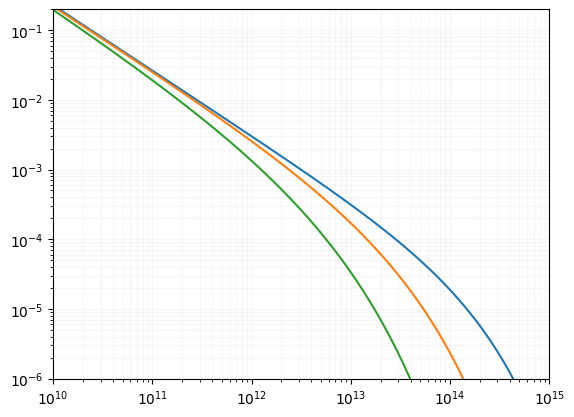

In [1193]:
m = jnp.geomspace(1e10,3.5e15,100)
# m = 3e14
for z in [0,1,2]:
    dndlnm = get_hmf_at_z_and_m(z,m,params_values_dict = allpars)
    # print(dndlnm)
    plt.plot(m,dndlnm)
plt.loglog()
plt.grid(which='both',alpha=0.1)
plt.ylim(1e-6,2e-1)
plt.xlim(1e10,1e15)

## Comoving Volume factor

In [1194]:
def dVdzdOmega(z, params_values_dict = None):

    rparams = classy_sz.get_all_relevant_params(params_values_dict = params_values_dict)
    h = rparams['h']
    dAz = classy_sz.get_angular_distance_at_z(z,params_values_dict = params_values_dict) * h
    # dAz = classy_sz.get_angular_distance_at_z(z,params_values_dict = cosmo_params)/(1+z)*h # in Mpc/h
    Hz = classy_sz.get_hubble_at_z(z,params_values_dict = params_values_dict) / h # in Mpc^(-1) h
    # print(Hz)

    return (1+z)**2*dAz**2/Hz

## Simpson Integration in JAX (c.f. Inigo's modification)

In [1195]:
def simpson(y, *, x=None, dx=1.0, axis=-1):
    y = jnp.asarray(y)
    nd = len(y.shape)
    N = y.shape[axis]
    last_dx = dx
    returnshape = 0
    if x is not None:
        x = jnp.asarray(x)
        if len(x.shape) == 1:
            shapex = [1] * nd
            shapex[axis] = x.shape[0]
            saveshape = x.shape
            returnshape = 1
            x = x.reshape(tuple(shapex))
        elif len(x.shape) != len(y.shape):
            raise ValueError("If given, shape of x must be 1-D or the "
                             "same as y.")
        if x.shape[axis] != N:
            raise ValueError("If given, length of x along axis must be the "
                             "same as y.")
    if N % 2 == 0:
        val = 0.0
        result = 0.0
        slice_all = (slice(None),) * nd
        if N == 2:
            # need at least 3 points in integration axis to form parabolic
            # segment. If there are two points then any of 'avg', 'first',
            # 'last' should give the same result.
            slice1 = tupleset(slice_all, axis, -1)
            slice2 = tupleset(slice_all, axis, -2)
            if x is not None:
                last_dx = x[slice1] - x[slice2]
            val += 0.5 * last_dx * (y[slice1] + y[slice2])
        else:
            # use Simpson's rule on first intervals
            result = _basic_simpson(y, 0, N-3, x, dx, axis)
            slice1 = tupleset(slice_all, axis, -1)
            slice2 = tupleset(slice_all, axis, -2)
            slice3 = tupleset(slice_all, axis, -3)
            h = jnp.asarray([dx, dx], dtype=jnp.float64)
            if x is not None:
                # grab the last two spacings from the appropriate axis
                hm2 = tupleset(slice_all, axis, slice(-2, -1, 1))
                hm1 = tupleset(slice_all, axis, slice(-1, None, 1))
                diffs = jnp.float64(jnp.diff(x, axis=axis))
                h = [jnp.squeeze(diffs[hm2], axis=axis),
                     jnp.squeeze(diffs[hm1], axis=axis)]
            num = 2 * h[1] ** 2 + 3 * h[0] * h[1]
            den = 6 * (h[1] + h[0])
            alpha = jnp.true_divide(
                num,
                den,
            )
            num = h[1] ** 2 + 3.0 * h[0] * h[1]
            den = 6 * h[0]
            beta = jnp.true_divide(
                num,
                den,
            )
            num = 1 * h[1] ** 3
            den = 6 * h[0] * (h[0] + h[1])
            eta = jnp.true_divide(
                num,
                den,
            )
            result += alpha*y[slice1] + beta*y[slice2] - eta*y[slice3]
        result += val
    else:
        result = _basic_simpson(y, 0, N-2, x, dx, axis)
    if returnshape:
        x = x.reshape(saveshape)
    return result
def _basic_simpson(y, start, stop, x, dx, axis):
    nd = len(y.shape)
    if start is None:
        start = 0
    step = 2
    slice_all = (slice(None),)*nd
    slice0 = tupleset(slice_all, axis, slice(start, stop, step))
    slice1 = tupleset(slice_all, axis, slice(start+1, stop+1, step))
    slice2 = tupleset(slice_all, axis, slice(start+2, stop+2, step))
    if x is None:  # Even-spaced Simpson's rule.
        result = jnp.sum(y[slice0] + 4.0*y[slice1] + y[slice2], axis=axis)
        result *= dx / 3.0
    else:
        # Account for possibly different spacings.
        #    Simpson's rule changes a bit.
        h = jnp.diff(x, axis=axis)
        sl0 = tupleset(slice_all, axis, slice(start, stop, step))
        sl1 = tupleset(slice_all, axis, slice(start+1, stop+1, step))
        h0 = h[sl0].astype(float)
        h1 = h[sl1].astype(float)
        hsum = h0 + h1
        hprod = h0 * h1
        h0divh1 = jnp.true_divide(h0, h1)
        tmp = hsum/6.0 * (y[slice0] *
                          (2.0 - jnp.true_divide(1.0, h0divh1)) +
                          y[slice1] * (hsum *
                                       jnp.true_divide(hsum, hprod)) +
                          y[slice2] * (2.0 - h0divh1))
        result = jnp.sum(tmp, axis=axis)
    return result
def tupleset(t, i, value):
    l = list(t)
    l[i] = value
    return tuple(l)

In [1196]:
# def get_ell_range(params_values_dict = None):

#     # Get cosmological parameters
#     rparams = classy_sz.get_all_relevant_params(params_values_dict = params_values_dict)
#     l_min = rparams['ell_min']
#     l_max = rparams['ell_max']
#     dlogell = rparams['dlogell']

#     log10_l_min = jnp.log10(l_min)
#     log10_l_max = jnp.log10(l_max)
#     num = int((log10_l_max - log10_l_min) / dlogell) + 1
#     # print(num)

#     # Define evaluation ell values (uniform grid)
#     ell_eval = jnp.logspace(log10_l_min, log10_l_max, num=num)
    
#     return ell_eval
def get_ell_range():
    # Predefined list of ell values
    # ell_eval = jnp.array([10., 13.5, 18., 23.5, 30.5, 40., 52.5, 68.5, 89.5, 
    #                      117., 152.5, 198., 257.5, 335.5, 436.5, 567.5, 738., 959.5])
    ell_eval = jnp.array([2.00000000e+00, 2.44280552e+00, 2.98364940e+00, 3.64423760e+00,
       4.45108186e+00, 5.43656366e+00, 6.64023385e+00, 8.11039993e+00,
       9.90606485e+00, 1.20992949e+01, 1.47781122e+01, 1.80500270e+01,
       2.20463528e+01, 2.69274761e+01, 3.28892935e+01, 4.01710738e+01,
       4.90650604e+01, 5.99282001e+01, 7.31964689e+01, 8.94023690e+01,
       1.09196300e+02, 1.33372662e+02, 1.62901737e+02, 1.98968631e+02,
       2.43020835e+02, 2.96826318e+02, 3.62544484e+02, 4.42812832e+02,
       5.40852815e+02, 6.60599120e+02, 8.06857587e+02, 9.85498082e+02,
       1.20369008e+03, 1.47019038e+03, 1.79569458e+03, 2.19326632e+03,
       2.67886153e+03, 3.27196886e+03, 3.99639179e+03, 4.88120396e+03,
       5.96191597e+03, 7.28190061e+03])
    return ell_eval

## Set up the integration grid

In [1197]:
def get_integral_grid(params_values_dict = None):
    
    rparams = classy_sz.get_all_relevant_params(params_values_dict = params_values_dict)
    allparams = classy_sz.get_all_relevant_params(params_values_dict = params_values_dict)
    

    z_min = allparams['z_min']
    z_max = allparams['z_max']
    z_grid = jnp.geomspace(z_min, z_max, 100)
    
    h = rparams['h']
    # Define an m_grid:
    M_min = allparams['M_min']
    M_max = allparams['M_max']
    m_grid_yl = jnp.geomspace(M_min,M_max,100)
    # m_grid_dndlnm = jnp.geomspace(M_min,M_max,100) * h


    def get_yellm_for_z(zp):
        ell, y_ellm = y_ell_interpolate(zp, m_grid_yl, params_values_dict = params_values_dict)
        # print(y_ellm)
        # print(ell.shape)
        # ell, y_ellm = y_ell_complete(zp, m_grid_yl, params_values_dict=cosmo_params)
        return ell, y_ellm
    
    def get_hmf_for_z(zp):
        # dndlnm = get_hmf_at_z_and_m(z = zp, m=m_grid_dndlnm, params_values_dict=cosmo_params)
        dndlnm = get_hmf_at_z_and_m(z = zp, m=m_grid_yl, params_values_dict= params_values_dict)
        return dndlnm
 

    # Vectorize this function over `z_grid`
    # y_ell_mz_grid = jax.vmap(get_yellm_for_z)(z_grid)
    ell, y_ell_mz_grid = jax.vmap(get_yellm_for_z)(z_grid)
    dndlnm_grid = jax.vmap(get_hmf_for_z)(z_grid)
    # print(y_ell_mz_grid.shape)
    # print(dndlnm_grid.shape)

    # print(z_grid)
    # print(y_ell_mz_grid)
    # Ensure `dndlnm_grid` has a compatible shape for broadcasting
    dndlnm_grid_expanded = dndlnm_grid[:, :, None]  # Shape becomes (100, 100, 1)

    comov_vol = dVdzdOmega(z_grid, params_values_dict=params_values_dict)

    # Expand comov_vol to align with the shape of `result`
    comov_vol_expanded = comov_vol[:, None, None]  # Shape becomes (100, 1, 1)

    # Perform element-wise multiplication
    result = y_ell_mz_grid**2 * dndlnm_grid_expanded * comov_vol_expanded  # Shape becomes (100, 100, 18)= (dim_z, dim_m, dim_ell)
    # result = y_ell_mz_grid
    # prefactor = y_ell_prefactor(z_grid, m_grid_yl, params_values_dict=cosmo_params)

    # Perform element-wise multiplication
    # result = y_ell_mz_grid * dndlnm_grid_expanded  # Shape becomes (100, 100, 18)  
    # print(result.shape) 
    # print(ell.shape)
    return result
    
    

In [1198]:
def compute_integral(params_values_dict = None):

    allparams = classy_sz.get_all_relevant_params(params_values_dict = params_values_dict)

    integrand = get_integral_grid(params_values_dict = params_values_dict) # shape is (dim_z, dim_m, dim_ell) 
    # ell = get_integral_grid()[0]
    # print(integrand.shape)
    # print(ell.shape)

    z_min = allparams['z_min']
    z_max = allparams['z_max']
    z_grid = jnp.geomspace(z_min, z_max, 100)
    

    # Define an m_grid:
    M_min = allparams['M_min']
    M_max = allparams['M_max']
    m_grid = jnp.geomspace(M_min,M_max,100)
    logm_grid = jnp.log(m_grid)


    ell = get_ell_range()
    # ell = y_ell_complete(z=1, m=m_grid, params_values_dict = cosmo_params)[0]
    # This will store the integrated value for each ell
    C_yy = jnp.zeros(len(ell))


    for i in range(len(ell)):
        # 1) Integrate over m
        #    integrand[:, :, i] has shape (dim_z, dim_m)
        partial_m = simpson(integrand[:, :, i], x=logm_grid, dx=(logm_grid[1]-logm_grid[0]),axis=1)
        # partial_m = jnp.trapezoid(integrand[:, :, i], x=logm_grid, dx=(logm_grid[1]-logm_grid[0]),axis=1)
        # partial_m = simpson(integrand[:, :, i], x=m_grid, axis=1)
        # partial_m now has shape (dim_z,)

        # 2) Integrate the result over z
        result = simpson(partial_m, x=z_grid, dx = (z_grid[1]-z_grid[0]), axis=0)
        # result = jnp.trapezoid(partial_m, x=z_grid, dx = (z_grid[1]-z_grid[0]), axis=0)

        # Store the result for this ell
        C_yy = C_yy.at[i].set(result)
            
    return C_yy  

## Compute the integral

In [1199]:
# %timeit -n 10 -r 5  C_yy = compute_integral(params_values_dict = allpars)
ell = get_ell_range()
C_yy = compute_integral(params_values_dict = allpars)

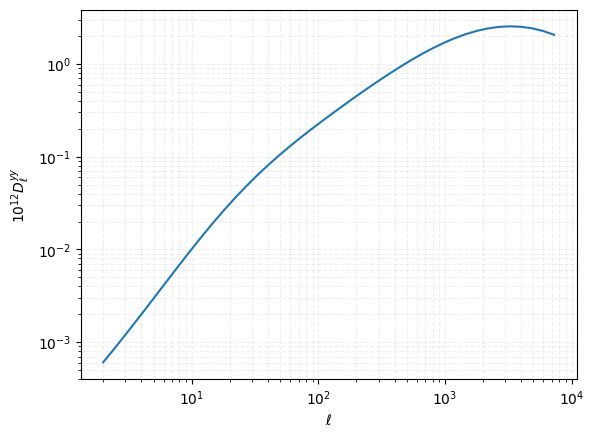

In [1200]:
# ell=ell-0.5
plt.plot(ell, ell*(ell+1)*C_yy*1e12/(2*jnp.pi))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$10^{12} D_{\ell}^{y y}$')
plt.grid(visible=True, which="both", alpha=0.2, linestyle='--')
plt.show()

In [1201]:
# Calculate the y values for the plot
y_values = ell * (ell + 1) * C_yy * 1e12/(2*jnp.pi)
# y_values = ell * (ell + 1) * C_yy * 1e12

# Find the maximum value and the corresponding ell
max_y = np.max(y_values)
ell_max = ell[np.argmax(y_values)]
print("ell peak",ell_max)
print("y_max:",max_y)

ell peak 3271.96886
y_max: 2.548313004903222


In [1202]:
y_values

Array([6.05914757e-04, 8.47422777e-04, 1.19371922e-03, 1.69155862e-03,
       2.40775335e-03, 3.43640144e-03, 4.90722143e-03, 6.99370789e-03,
       9.91867905e-03, 1.39542598e-02, 1.94151918e-02, 2.66493769e-02,
       3.60329077e-02, 4.79693652e-02, 6.28839157e-02, 8.12219701e-02,
       1.03481558e-01, 1.30274969e-01, 1.62393985e-01, 2.00864904e-01,
       2.46979925e-01, 3.02297954e-01, 3.68611033e-01, 4.47876399e-01,
       5.42110254e-01, 6.53228201e-01, 7.82819663e-01, 9.31839819e-01,
       1.10021713e+00, 1.28640415e+00, 1.48691247e+00, 1.69594282e+00,
       1.90521970e+00, 2.10415864e+00, 2.28044792e+00, 2.42106785e+00,
       2.51369156e+00, 2.54831300e+00, 2.51887147e+00, 2.42447144e+00,
       2.26991535e+00, 2.06532867e+00], dtype=float64)

In [1203]:
cl_yy_mod = jnp.array([6.19417603e-04, 8.77347992e-04, 1.24932097e-03, 1.78642458e-03,
       2.56158796e-03, 3.67701090e-03, 5.27295430e-03, 7.53578208e-03,
       1.07031406e-02, 1.50629373e-02, 2.09483340e-02, 2.87279455e-02,
       3.88003979e-02, 5.15948466e-02, 6.75554125e-02, 8.71538487e-02,
       1.10917877e-01, 1.39509501e-01, 1.73790227e-01, 2.14858057e-01,
       2.64104804e-01, 3.23203749e-01, 3.94046270e-01, 4.78651284e-01,
       5.79186171e-01, 6.97522276e-01, 8.35220428e-01, 9.93201932e-01,
       1.17103737e+00, 1.36690425e+00, 1.57672044e+00, 1.79414378e+00,
       2.01008331e+00, 2.21321359e+00, 2.39076857e+00, 2.52918148e+00,
       2.61593538e+00, 2.64133660e+00, 2.59951975e+00, 2.49067650e+00,
       2.32069591e+00, 2.10110329e+00])
y_values/cl_yy_mod

Array([0.97820074, 0.96589128, 0.95549442, 0.94689618, 0.93994561,
       0.93456384, 0.93063986, 0.92806663, 0.92670735, 0.92639699,
       0.92681317, 0.92764646, 0.92867366, 0.92973171, 0.93084941,
       0.93193785, 0.93295653, 0.93380714, 0.9344253 , 0.93487257,
       0.93515877, 0.93531698, 0.93545114, 0.935705  , 0.93598618,
       0.93649798, 0.93726116, 0.93821789, 0.9395235 , 0.94110772,
       0.94304129, 0.94526584, 0.94783121, 0.95072552, 0.95385557,
       0.95725351, 0.96091501, 0.96478162, 0.9689757 , 0.97341884,
       0.97811839, 0.98297341], dtype=float64)

### Note, peak value is too low, should be ~2.60 from class_sz, cannot find the reason

## tSZ trispectrum

In [1204]:
def get_integral_grid_trisp(params_values_dict=None):

    # 1) Get y_\ell(z, m) over grids of z and m
    rparams = classy_sz.get_all_relevant_params(params_values_dict=params_values_dict)
    allparams = classy_sz.get_all_relevant_params(params_values_dict=params_values_dict)
    
    z_min = allparams['z_min']
    z_max = allparams['z_max']
    z_grid = jnp.geomspace(z_min, z_max, 100)

    M_min = allparams['M_min']
    M_max = allparams['M_max']
    m_grid = jnp.geomspace(M_min, M_max, 100)

    # y_ell_mz_grid: shape = (n_z, n_m, n_ell)
    def get_yellm_for_z(zp):
        # Returns ell (length n_ell) and y_ellm (length n_m x n_ell)
        # but typically we stack in shape (n_m, n_ell)
        ell_vals, y_ellm = y_ell_interpolate(zp, m_grid, params_values_dict=params_values_dict)
        return y_ellm
    

    # Vectorize over z
    y_ell_mz_grid = jax.vmap(get_yellm_for_z)(z_grid)  
    # shape = (n_z, n_m, n_ell)

    # Save ell from a single call (assuming same for all z):
    ell_vals, _ = y_ell_interpolate(z_grid[0], m_grid, params_values_dict=params_values_dict)
    # or keep a separate function get_ell_range() if you prefer
    ell = ell_vals  # shape = (n_ell,)

    # 2) Get halo mass function dndlnm over the same z,m
    def get_hmf_for_z(zp):
        return get_hmf_at_z_and_m(z=zp, m=m_grid, params_values_dict=params_values_dict)
    dndlnm_grid = jax.vmap(get_hmf_for_z)(z_grid)  
    # shape = (n_z, n_m)

    # 3) Get comoving volume element dV/dz/dOmega over z
    comov_vol = dVdzdOmega(z_grid, params_values_dict=params_values_dict)
    # shape = (n_z,)

    # Expand dimensions for consistent broadcasting:
    #   dndlnm_grid_expanded: shape (n_z, n_m, 1, 1)
    dndlnm_grid_expanded = dndlnm_grid[:, :, None, None]
    #   comov_vol_expanded: shape (n_z, 1, 1, 1)
    comov_vol_expanded   = comov_vol[:, None, None, None]

    # 4) Construct the integrand:
    # y^2 for each ell
    y_ell_sq = y_ell_mz_grid**2  # shape: (n_z, n_m, n_ell)

    # We need (n_z, n_m, n_ell, n_ell'). 
    # The product y_ell_sq[..., None] * y_ell_sq[..., None, :] 
    # gives shape (n_z, n_m, n_ell, n_ell)
    # i.e. y_ell^2 * y_ell'^2
    integrand = y_ell_sq[:, :, :, None] * y_ell_sq[:, :, None, :]
    # print(integrand.shape)

    # Now multiply by dndlnm and comov. 
    integrand = integrand * dndlnm_grid_expanded * comov_vol_expanded
    # final shape = (n_z, n_m, n_ell, n_ell)

    return ell, integrand


In [1205]:
def compute_trispectrum(params_values_dict=None):
    # 1) Build integrand
    ell, integrand = get_integral_grid_trisp(params_values_dict)

    # 2) Construct z and m grids (consistent with what's in get_integral_grid_trisp)
    allparams = classy_sz.get_all_relevant_params(params_values_dict=params_values_dict)
    z_min = allparams['z_min']
    z_max = allparams['z_max']
    z_grid = jnp.geomspace(z_min, z_max, 100)
    
    M_min = allparams['M_min']
    M_max = allparams['M_max']
    m_grid = jnp.geomspace(M_min, M_max, 100)
    logm_grid = jnp.log(m_grid)

    # integrand shape = (n_z, n_m, n_ell, n_ell')

    # 3) Integrate over m (axis=1) using log(m) or m—depending on your definition
    # partial_m shape = (n_z, n_ell, n_ell')
    partial_m = simpson(integrand, x=logm_grid, axis=1)  

    # 4) Integrate over z (axis=0)
    # final shape = (n_ell, n_ell')
    T_ell_ellprime = simpson(partial_m, x=z_grid, axis=0)

    # T_ell_ellprime[i,j] ~ T_{ell_i, ell_j}
    return ell, T_ell_ellprime


In [1206]:
# %timeit -n 10 -r 5 ell, T_ell_ellprime = compute_trispectrum(params_values_dict=allpars)
ell, T_ell_ellprime = compute_trispectrum(params_values_dict=allpars)

In [1207]:
ell, T_ell_ellprime = compute_trispectrum(params_values_dict=allpars)
# print(T_ell_ellprime*1e24)
# print(C_yy)
# Precompute the factor: (ell*(ell+1)) for each ell
ell_factor = ell * (ell + 1.0)   # shape (n_ell,)

# Broadcast to 2D via outer product
# shape: (n_ell, n_ell)
ell2D_factor = jnp.outer(ell_factor, ell_factor)

# The overall scaling factor
prefactor = 1 / ((2.0 * jnp.pi)**2)

# Finally, multiply element-wise
scaled_T_ell_ellprime = T_ell_ellprime * ell2D_factor * prefactor

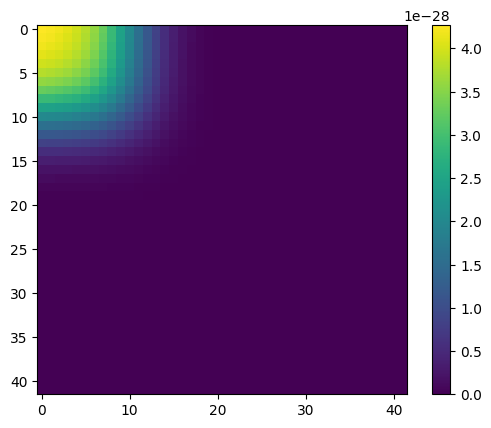

In [1208]:
plt.imshow(T_ell_ellprime)
plt.colorbar()

In [1209]:
ell.shape

(42,)

(42, 42)

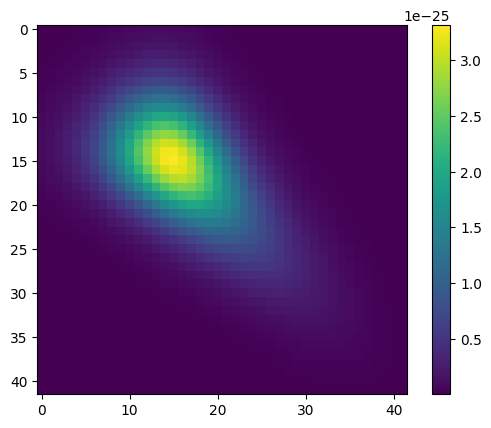

In [1210]:
plt.imshow(scaled_T_ell_ellprime)
plt.colorbar()
scaled_T_ell_ellprime.shape

## The full tSZ covariance matrix (G+NG)

In [1211]:
def compute_tsz_covariance(params_values_dict=None, noise_ell=None, f_sky=1.0):
    """
    Returns M_llp
    Time to compute this = time to compute tSZ power spectrum + time to compute tSZ trispectrum
    """

    # 1) Compute the tSZ power spectrum C_ell^{yy}
    C_yy = compute_integral(params_values_dict=params_values_dict)  
    # Shape: (n_ell,)

    # 2) Compute the tSZ trispectrum T_{ell,ell'}^{yy} and grab the ell array
    ell_arr, T_ell_ellprime = compute_trispectrum(params_values_dict=params_values_dict)
    # T_ell_ellprime shape: (n_ell, n_ell)
    # ell_arr shape:        (n_ell,)

    # 3) If no noise is given, set it to zero
    if noise_ell is None:
        noise_ell = jnp.zeros_like(C_yy)
    # noise_ell shape: (n_ell,)

    # 4) Construct the diagonal term
    #    diag_term[ell] = [4π (C_ell + N_ell)^2] / [ell + 1/2]
    diag_term = (4.0 * jnp.pi) * (C_yy + noise_ell)**2 / (ell_arr + 0.5)

    # 5) Build the full covariance matrix
    #    M = diag_term * δ_{ell,ell'} + T_{ell,ell'}
    #    Then multiply by 1 / [4π f_sky]
    M = jnp.diag(diag_term) + T_ell_ellprime

    M_G = jnp.diag(diag_term)/ (4.0 * jnp.pi * f_sky)

    M = M / (4.0 * jnp.pi * f_sky)

    return ell_arr, M, M_G


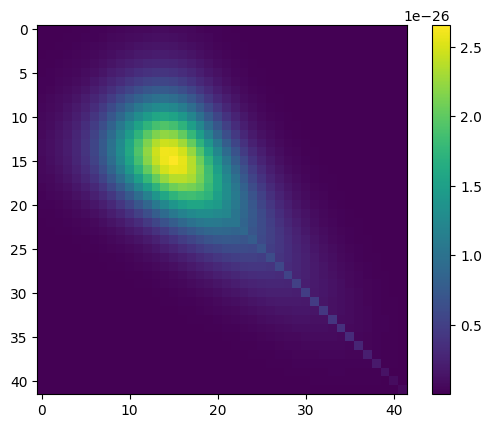

In [1212]:
# Suppose you have your parameter dictionary `allpars`
# %timeit -n 10 -r 5 ell_arr, M = compute_tsz_covariance(params_values_dict=allpars, noise_ell=None, f_sky=1.0)
ell_arr, M, M_G= compute_tsz_covariance(params_values_dict=allpars, noise_ell=None, f_sky=1.0)

# print("ell array:", ell_arr)
# print("Covariance matrix shape:", M.shape)
# e.g. (n_ell, n_ell)
scaled_M_llp =M * ell2D_factor * prefactor
scaled_M_G_llp = M_G * ell2D_factor * prefactor

plt.imshow(scaled_M_llp)
plt.colorbar()

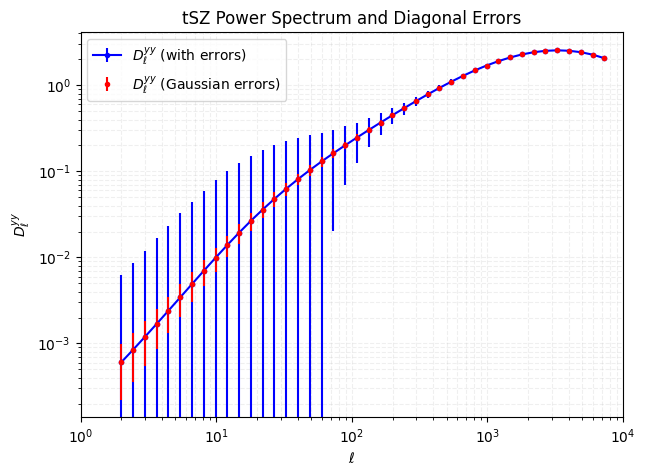

In [1213]:
# Now you can, for example, slice out the diagonal to get error bars:
diag_vals = jnp.diag(scaled_M_llp)   # shape (n_ell,)
diag_vals_G = jnp.diag(scaled_M_G_llp)   # shape (n_ell,)
# print(diag_vals_G)
sigma = jnp.sqrt(diag_vals)
sigma_G = jnp.sqrt(diag_vals_G)
D_yy = ell * (ell + 1) * C_yy / (2 * jnp.pi)
# Then you can plot C_ell^{yy} with error bars = sqrt(M_{ell,ell}).

plt.figure(figsize=(7,5))
plt.errorbar(ell_arr, D_yy*1e12, yerr=sigma*1e12, fmt='.-', label=r'$D_\ell^{yy}$ (with errors)', color='b')
plt.errorbar(ell_arr, D_yy*1e12, yerr=sigma_G*1e12, fmt='.', label=r'$D_\ell^{yy}$ (Gaussian errors)', color='r')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell^{yy}$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 1e4)
# plt.ylim(1e-3, 1e1)
plt.legend()
plt.title('tSZ Power Spectrum and Diagonal Errors')
plt.grid(visible=True, which="both", alpha=0.2, linestyle='--')
plt.show()
